<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RS_gr1/blob/main/Kozlov%20Alexey/InspectrumClinic_gr1_akozlov_20230529_04week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Рекомендательная система для профпатолога (INSPECTRUM CLINIC)**

Алексей Козлов 2023.05.29 - 2023.06.05 (4-я неделя): Балансировка датасета (Resample, метрика F1Score), построить модель FunctionalAPI

# Импорт библиотек

In [1]:
# Загрузка файлов из облака
import gdown
# Библиотека для работы с массивами данных
import numpy as np
# Библиотека для обработки и анализа данных
import pandas as pd
# Библиотека для построения графиков
import matplotlib.pyplot as plt
# Команда для отображения графики в ячейках среды Google Colaboratory
%matplotlib inline
# Библиотека для построения графиков
import seaborn as sns
#Для генерации случайных чисел
import random 
# Для округления
import math
import re

# Подключение класса создания модели Sequential
# Sequential – модуль для создания последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model
# Подключение класса Dense - полносвязный слой
# Dense – линейный (полносвязный) слой. Из таких слоев будет создана ваша нейросеть
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
# utils – модуль с полезными инструментами для подготовки данных
#Используем для to_categoricall
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
# подключаем колбэки
from tensorflow.keras.callbacks import LambdaCallback

from sklearn.preprocessing import StandardScaler
# Для разбивки на выборки
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from IPython.display import clear_output

# Для работы с датами
from datetime import datetime

#from keras import metrics

# Загрузка файла с исходными данными

In [2]:
# Загрузка файла датасета от 2023.05.08
url1 = 'https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%20%D0%BF%D1%80%D0%BE%D1%84%D0%BF%D0%B0%D1%82%D0%BE%D0%BB%D0%BE%D0%B3%20%D1%87%D0%B0%D1%81%D1%82%D1%8C.xlsx'
url2 = '/content/InspectrumClinic1.xlsx'
gdown.download(url1, url2, quiet=False)

Downloading...
From: https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%20%D0%BF%D1%80%D0%BE%D1%84%D0%BF%D0%B0%D1%82%D0%BE%D0%BB%D0%BE%D0%B3%20%D1%87%D0%B0%D1%81%D1%82%D1%8C.xlsx
To: /content/InspectrumClinic1.xlsx
100%|██████████| 32.4M/32.4M [00:02<00:00, 15.7MB/s]


'/content/InspectrumClinic1.xlsx'

In [3]:
# Чтение данных (df - DataFrame)
df1 = pd.read_excel(url2)

In [4]:
# Выведем информацию о заполненности ячеек каждого признака
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982 entries, 0 to 1981
Columns: 4587 entries, ДокументПрохождениеМедосмотра to Офтальмология1_ДвигательныйАппаратГлазДополнение_ЗначениеПредставление
dtypes: bool(1), datetime64[ns](43), float64(1253), object(3290)
memory usage: 69.3+ MB


In [5]:
print(f'размеры датафрейма: df1: {df1.shape}')

размеры датафрейма: df1: (1982, 4587)


In [6]:
# общее количество пропусков во всей таблице
nan_cell_count = df1.isna().sum().sum()
# Переведем полученное значение в проценты. Для этого поделим количество пропусков на количество ячеек и умножим на 100:
nan_cell_count_proc = nan_cell_count*100/df1.size
print(f'общее количество пропусков во всей таблице: {nan_cell_count}, {round(nan_cell_count_proc, 2)}%')

общее количество пропусков во всей таблице: 8106978, 89.17%


# Балансировка датасета Resample

In [7]:
# Целевая колонка 'ЗаключениеМК'
nan_lst = df1[df1['ЗаключениеМК'].isnull()].index
print(f'"ЗаключениеМК": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['ЗаключениеМК'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

"ЗаключениеМК": число строк с пустыми значениями: 407
10: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ОграниченноГоден', nan, 'машинист бульдозера', 'Газоспасатель', ' Газоспасатель']


In [8]:
# Подсчитаем число строк по каждому целевому значению
# Получаем список значений колонки
col_inx = df1.columns.get_loc('ЗаключениеМК')
col_lst = df1.iloc[:, col_inx].tolist()
# print(f'df1.shape[0]: {df1.shape[0]}: len(col_lst): {len(col_lst)}, col_lst: {col_lst}')

# 6: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ОграниченноГоден']

lst0 = list() #0 - ВременноНегоден
lst1 = list() #1 - ГоденСКоррекциейЗрения
lst2 = list() #2 - ГоденБезРаботНаВысотах
lst3 = list() #3 - НуждаетсяВДообследованииИЛечении
lst4 = list() #4 - ОграниченноГоден
lst5 = list() #5 - Годен

# Подсчитываем число целевых значений по категориям
# и заполняем списки индексов соответствующих значений
# Пробегаем по всем строкам текущей колонки
for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}')
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      if not (('машинист бульдозера' == i_elem) or ('Газоспасатель' == i_elem) or (' Газоспасатель' == i_elem)):
        # print(f'{i}=>{df1.shape[0]}: i_elem: {i_elem}')
        if 'ВременноНегоден' == i_elem:
          lst0.append(i)
        elif 'ГоденСКоррекциейЗрения' == i_elem:
          lst1.append(i)
        elif 'ГоденБезРаботНаВысотах' == i_elem:
          lst2.append(i)
        elif 'НуждаетсяВДообследованииИЛечении' == i_elem:
          lst3.append(i)
        elif 'ОграниченноГоден' == i_elem:
          lst4.append(i)
        elif 'Годен' == i_elem:
          lst5.append(i)
        else:
          print(f'{i}->{df1.shape[0]}: i_elem: {i_elem} -> НЕИЗВЕСТНЫЙ ИНДЕКС-ТИП')

print(f'df1 число строк: {df1.shape[0]}')

print(f'0: ВременноНегоден: {len(lst0)}')
print(f'1: ГоденСКоррекциейЗрения: {len(lst1)}')
print(f'2: ГоденБезРаботНаВысотах: {len(lst2)}')
print(f'3: НуждаетсяВДообследованииИЛечении: {len(lst3)}')
print(f'4: ОграниченноГоден: {len(lst4)}')
print(f'5: Годен: {len(lst5)}')

print('проверочная сумма по отдельным значениям, c учетом nan и запрещенных значений:')
print(f'  {df1.shape[0]} -> {len(lst0)+len(lst1)+len(lst2)+len(lst3)+len(lst4)+len(lst5)}')

df1 число строк: 1982
0: ВременноНегоден: 9
1: ГоденСКоррекциейЗрения: 123
2: ГоденБезРаботНаВысотах: 1
3: НуждаетсяВДообследованииИЛечении: 2
4: ОграниченноГоден: 2
5: Годен: 1434
проверочная сумма по отдельным значениям, c учетом nan и запрещенных значений:
  1982 -> 1571


In [9]:
# создаем копию нужных строк и добавляем их в отдельный df
adf0 = df1.loc[lst0].copy()
print(f'размеры датафрейма adf0: {adf0.shape}, len(lst0): {len(lst0)}')

adf1 = df1.loc[lst1].copy()
print(f'размеры датафрейма adf1: {adf1.shape}, len(lst1): {len(lst1)}')

adf2 = df1.loc[lst2].copy()
print(f'размеры датафрейма adf2: {adf2.shape}, len(lst2): {len(lst2)}')

adf3 = df1.loc[lst3].copy()
print(f'размеры датафрейма adf3: {adf3.shape}, len(lst3): {len(lst3)}')

adf4 = df1.loc[lst4].copy()
print(f'размеры датафрейма adf4: {adf4.shape}, len(lst4): {len(lst4)}')

размеры датафрейма adf0: (9, 4587), len(lst0): 9
размеры датафрейма adf1: (123, 4587), len(lst1): 123
размеры датафрейма adf2: (1, 4587), len(lst2): 1
размеры датафрейма adf3: (2, 4587), len(lst3): 2
размеры датафрейма adf4: (2, 4587), len(lst4): 2


In [10]:
print(f'размеры датафрейма: df1: {df1.shape}')

# добавляем новый df в исходный df

for i in range(1):
  for j in range(20):
    df1 = pd.concat([df1, adf0], ignore_index=True)
  df1 = pd.concat([df1, adf1], ignore_index=True)
  for j in range(200):
    df1 = pd.concat([df1, adf2], ignore_index=True)
  for j in range(100):
    df1 = pd.concat([df1, adf3], ignore_index=True)
    df1 = pd.concat([df1, adf4], ignore_index=True)

print('='*50)
print(f'размеры датафрейма: df1: {df1.shape}')

размеры датафрейма: df1: (1982, 4587)
размеры датафрейма: df1: (2885, 4587)


In [11]:
# Смотрим новые значения целевой колонки
lst0.clear()
lst1.clear()
lst2.clear()
lst3.clear()
lst4.clear()
lst5.clear()

col_lst = df1.iloc[:, col_inx].tolist()
for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  if (i_elem == i_elem):
    if i_elem:
      if not (('машинист бульдозера' == i_elem) or ('Газоспасатель' == i_elem) or (' Газоспасатель' == i_elem)):
        if 'ВременноНегоден' == i_elem:
          lst0.append(i)
        elif 'ГоденСКоррекциейЗрения' == i_elem:
          lst1.append(i)
        elif 'ГоденБезРаботНаВысотах' == i_elem:
          lst2.append(i)
        elif 'НуждаетсяВДообследованииИЛечении' == i_elem:
          lst3.append(i)
        elif 'ОграниченноГоден' == i_elem:
          lst4.append(i)
        elif 'Годен' == i_elem:
          lst5.append(i)
        else:
          print(f'{i}->{df1.shape[0]}: i_elem: {i_elem} -> НЕИЗВЕСТНЫЙ ИНДЕКС-ТИП')

print(f'df1 число строк: {df1.shape[0]}')

print(f'0: ВременноНегоден: {len(lst0)}')
print(f'1: ГоденСКоррекциейЗрения: {len(lst1)}')
print(f'2: ГоденБезРаботНаВысотах: {len(lst2)}')
print(f'3: НуждаетсяВДообследованииИЛечении: {len(lst3)}')
print(f'4: ОграниченноГоден: {len(lst4)}')
print(f'5: Годен: {len(lst5)}')

print('проверочная сумма по отдельным значениям, c учетом nan и запрещенных значений:')
print(f'  {df1.shape[0]} -> {len(lst0)+len(lst1)+len(lst2)+len(lst3)+len(lst4)+len(lst5)}')
print(f'  Годен: {len(lst5)}')
print(f'  Негоден, Ограниченно годен: {len(lst0)+len(lst1)+len(lst2)+len(lst3)+len(lst4)}')

df1 число строк: 2885
0: ВременноНегоден: 189
1: ГоденСКоррекциейЗрения: 246
2: ГоденБезРаботНаВысотах: 201
3: НуждаетсяВДообследованииИЛечении: 202
4: ОграниченноГоден: 202
5: Годен: 1434
проверочная сумма по отдельным значениям, c учетом nan и запрещенных значений:
  2885 -> 2474
  Годен: 1434
  Негоден, Ограниченно годен: 1040


In [12]:
del lst0
del lst1
del lst2
del lst3
del lst4
del lst5

del adf0
del adf1
del adf2
del adf3
del adf4

# Удаление из датафрейма строк с пустыми и ошибочными целевыми значениями

In [13]:
# Целевая колонка 'ЗаключениеМК'
nan_lst = df1[df1['ЗаключениеМК'].isnull()].index
print(f'"ЗаключениеМК": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['ЗаключениеМК'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

"ЗаключениеМК": число строк с пустыми значениями: 407
10: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ОграниченноГоден', nan, 'машинист бульдозера', 'Газоспасатель', ' Газоспасатель']


In [14]:
# Удаляем строки с пустыми и запрещенными значениями в целевой колонке 'ЗаключениеМК'
# nan, 'машинист бульдозера', 'Газоспасатель', ' Газоспасатель'
df1 = df1.drop(df1[(df1['ЗаключениеМК'].isnull()) | (df1['ЗаключениеМК'] == 'машинист бульдозера') | (df1['ЗаключениеМК'] == 'Газоспасатель') | (df1['ЗаключениеМК'] == ' Газоспасатель') ].index)
print(f'размеры датафрейма после удаления строк: {df1.shape}')
u_lst = df1['ЗаключениеМК'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

размеры датафрейма после удаления строк: (2474, 4587)
6: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ОграниченноГоден']


# Создаем второй датафрейм для обучения нейросети

In [15]:
# Заполняем колонку ЗаключениеМКК категориальными признаками
# по данным колонки ЗаключениеМК
# 0 - негоден, 1 - годен с ограничениями, 2 - годен
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода 'ЗаключениеМК'
#~~~~~~~~~~~~~~~~~~~~~~~~
def getConclusionCategory(arg):
  '''
    Получение целевого категориального значения по текстовому описанию
    вход:
        arg: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ОграниченноГоден']
    выход:
        retVal: 0 - негоден, 1 - годен с ограничениями, 2 - годен
  '''
  if ('ГоденСКоррекциейЗрения' == arg) or ('ГоденБезРаботНаВысотах' == arg) or ('ОграниченноГоден' == arg):
    retVal = 1
  elif ('НуждаетсяВДообследованииИЛечении' == arg) or ('ВременноНегоден' == arg):
    retVal = 0
  else:
    retVal = 2

  return retVal

In [16]:
# Получаем список значений колонки
col_inx = df1.columns.get_loc('ЗаключениеМК')
col_lst = df1.iloc[:, col_inx].tolist()

# создаем numpy массив integer из нулей, число элементов равно числу строк нашего data frame
i_arr = np.zeros(df1.shape[0], dtype=int)

# Заполняем массив категориальными индексами
for i in range(df1.shape[0]):
  i_arr[i] = getConclusionCategory(col_lst[i])

# Преобразование массива в формат one_hot_encoding (3-класса)
i_arr2 = utils.to_categorical(i_arr, 3)
ohe_lst2 = i_arr2.astype(int).tolist()
# добавляем новую колонку 'ЗаключениеМКК' в DataFrame 'df1' из массива 'ohe_lst2'
df1 = df1.assign(ЗаключениеМКК=ohe_lst2)

# создаем новый датафрейм, в который будем заносить колонки для обучения нейросети
# и копируем колонку 'ЗаключениеМКК' в новый дата фрэйм
df2 = df1[['ЗаключениеМКК']].copy()
print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (2474, 4588), df2: (2474, 1)


,ЗаключениеМКК
0,"[0, 0, 1]"
1,"[0, 0, 1]"
2,"[0, 1, 0]"


# Категориальные признаки TODO ГоденНегоден

## Возраст

In [17]:
nan_lst = df1[df1['КлиентДатаРождения'].isnull()].index
print(f'"КлиентДатаРождения": число строк с пустыми значениями: {len(nan_lst)}')

"КлиентДатаРождения": число строк с пустыми значениями: 0


In [18]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода Возраст клиента
#~~~~~~~~~~~~~~~~~~~~~~~~
# Возраст клиента = ДатаЗавершенияМедосмотра - КлиентДатаРождения
#~~~~~~~~~~~~~~~~~~~~~~~~
def getAgeCategory(ageN, ageClassCount):
  '''
    Возраст превращаем в категориальный: до 18лет, далее через 5, всего 11 классов
    вход:
        ageN: возраст в годах
        ageClassCount: число классов
    выход:
        retVal: индекс категории: 0-17: 0, 18-22: 1, 23-27: 2, ...., 73..: 10
  '''
  #age2 = int((arg-13)/5)
  age2 = (ageN-13)/5
  retVal = max(0, min((ageClassCount-1),age2))
  return retVal

In [19]:
age_class_count = 11

# КлиентДатаРождения
col_inx = df1.columns.get_loc('КлиентДатаРождения')
col_lst = df1.iloc[:, col_inx].tolist()

datetime_lst1 = []
for time_stamp in col_lst:
  datetime_obj = time_stamp.to_pydatetime()
  datetime_lst1.append(datetime_obj)

# ДатаЗавершенияМедосмотра
nan_lst = df1[df1['ДатаЗавершенияМедосмотра'].isnull()].index
print(f'"ДатаЗавершенияМедосмотра": число строк с пустыми значениями: {len(nan_lst)}')
col_inx = df1.columns.get_loc('ДатаЗавершенияМедосмотра')
col_lst = df1.iloc[:, col_inx].tolist()

datetime_lst2 = []
for time_stamp in col_lst:
  datetime_obj = time_stamp.to_pydatetime()
  datetime_lst2.append(datetime_obj)

# рассчитываю возраст клиента
for i in range(df1.shape[0]):
  delta_dates21 = datetime_lst2[i].date() - datetime_lst1[i].date()
  delta_days21 = delta_dates21.days
  delta_years21 = delta_days21 // 365
  i_arr[i] = getAgeCategory(delta_years21, age_class_count)

# Преобразование массива в формат one_hot_encoding
i_arr2 = utils.to_categorical(i_arr, age_class_count)
ohe_lst2 = i_arr2.astype(int).tolist()

# добавляем новую колонку 'Возраст' в 'df2'
df2 = df2.assign(Возраст=ohe_lst2)

# удаление переменных, освобождение памяти
del datetime_lst1
del datetime_lst2

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

"ДатаЗавершенияМедосмотра": число строк с пустыми значениями: 0
размеры датафрейма: df1: (2474, 4588), df2: (2474, 2)


,ЗаключениеМКК,Возраст
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"


## КлиентПол

In [20]:
nan_lst = df1[df1['КлиентПол'].isnull()].index
print(f'"КлиентПол": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['КлиентПол'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

"КлиентПол": число строк с пустыми значениями: 0
2: ['Женский', 'Мужской']


In [21]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода 'КлиентПол'
#~~~~~~~~~~~~~~~~~~~~~~~~
def getGenderCategory(arg):
  '''
    Бинарный пол клиента
    вход:
        arg: ['Женский', 'Мужской']
    выход:
        retVal: 0 - Женский, 1 - Мужской
  '''
  if 'Женский' == arg:
    retVal = 0
  else:
    retVal = 1
  return retVal

In [22]:
col_inx = df1.columns.get_loc('КлиентПол')
col_lst = df1.iloc[:, col_inx].tolist()

for i in range(df1.shape[0]):
  i_arr[i] = getGenderCategory(col_lst[i])

# Преобразование массива в формат one_hot_encoding не провожу, так как бинарный тип
# добавляем новую колонку 'КлиентПол' в 'df2'
df2 = df2.assign(КлиентПол=i_arr)

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (2474, 4588), df2: (2474, 3)


,ЗаключениеМКК,Возраст,КлиентПол
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1


## ТипМедосмотра

In [23]:
nan_lst = df1[df1['ТипМедосмотра'].isnull()].index
print(f'"ТипМедосмотра": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['ТипМедосмотра'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

"ТипМедосмотра": число строк с пустыми значениями: 0
2: ['Периодический', 'Предварительный']


In [24]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода 'ТипМедосмотра'
#~~~~~~~~~~~~~~~~~~~~~~~~
def getTypeMedExaminationCategory(arg):
  '''
    Бинарный Тип Медосмотра
    вход:
        arg: ['Периодический', 'Предварительный']
    выход:
        retVal: 0 - Периодический, 1 - Предварительный
  '''
  if 'Периодический' == arg:
    retVal = 0
  else:
    retVal = 1
  return retVal

In [25]:
col_inx = df1.columns.get_loc('ТипМедосмотра')
col_lst = df1.iloc[:, col_inx].tolist()

for i in range(df1.shape[0]):
  i_arr[i] = getTypeMedExaminationCategory(col_lst[i])

# Преобразование массива в формат one_hot_encoding не провожу, так как бинарный тип
# добавляем новую колонку 'ТипМедосмотра' в 'df2'
df2 = df2.assign(ТипМедосмотра=i_arr)

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (2474, 4588), df2: (2474, 4)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0


## ПсихОсвидетельствование

In [26]:
nan_lst = df1[df1['ПсихОсвидетельствование'].isnull()].index
print(f'"ПсихОсвидетельствование": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['ПсихОсвидетельствование'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

"ПсихОсвидетельствование": число строк с пустыми значениями: 0
2: [False, True]


In [27]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода 'ПсихОсвидетельствование'
#~~~~~~~~~~~~~~~~~~~~~~~~
def getPsychicExaminationCategory(arg):
  '''
    Бинарный Тип ПсихОсвидетельствование
    вход:
        arg: [False, True]
    выход:
        retVal: 0 - False, 1 - True
  '''
  if False == arg:
    retVal = 0
  else:
    retVal = 1
  return retVal

In [28]:
col_inx = df1.columns.get_loc('ПсихОсвидетельствование')
col_lst = df1.iloc[:, col_inx].tolist()

for i in range(df1.shape[0]):
  i_arr[i] = getPsychicExaminationCategory(col_lst[i])

# Преобразование массива в формат one_hot_encoding не провожу, так как бинарный тип
# добавляем новую колонку 'ПсихОсвидетельствование' в 'df2'
df2 = df2.assign(ПсихОсвидетельствование=i_arr)

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (2474, 4588), df2: (2474, 5)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0


## ДиспансернаяГруппа

In [29]:
nan_lst = df1[df1['ДиспансернаяГруппа'].isnull()].index
print(f'"ДиспансернаяГруппа": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['ДиспансернаяГруппа'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

"ДиспансернаяГруппа": число строк с пустыми значениями: 149
5: ['I', 'IIIа', 'II', 'IIIб', nan]


In [30]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода 'ДиспансернаяГруппа'
#~~~~~~~~~~~~~~~~~~~~~~~~
def getDispensaryGroupCategory(arg):
  '''
    Категориальный Тип ДиспансернаяГруппа
    вход:
        один из элементов массива уникальных значений: ['I', 'IIIа', 'II', 'IIIб']
    выход:
        retVal: индекс элемента в массиве уникальных значений:
          0 - nan, 1 - 'I', 2 - 'IIIа', 3 - 'II', 4 - 'IIIб'
  '''
  if 'I' == arg:
    retVal = 1
  elif 'IIIа' == arg:
    retVal = 2
  elif 'II' == arg:
    retVal = 3
  elif 'IIIб' == arg:
    retVal = 4
  else:
    retVal = 0

  return retVal

In [31]:
dispensary_class_count = 5

col_inx = df1.columns.get_loc('ДиспансернаяГруппа')
col_lst = df1.iloc[:, col_inx].tolist()

# Заполняем массив категориальными индексами
for i in range(df1.shape[0]):
  i_arr[i] = getDispensaryGroupCategory(col_lst[i])

# Преобразование массива в формат one_hot_encoding (5-классов)
i_arr2 = utils.to_categorical(i_arr, dispensary_class_count)
ohe_lst2 = i_arr2.astype(int).tolist()

# добавляем новую колонку 'ДиспансернаяГруппа' в 'df2'
df2 = df2.assign(ДиспансернаяГруппа=ohe_lst2)

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (2474, 4588), df2: (2474, 6)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]"
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]"
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]"


In [32]:
df2.tail(2)

,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа
2883,"[0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]"
2884,"[0, 1, 0]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,0,0,"[0, 1, 0, 0, 0]"


## ВредныеФакторы

In [33]:
an_lst = df1[df1['ВредныеФакторы'].isnull()].index
print(f'"ВредныеФакторы": число строк с пустыми значениями: {len(nan_lst)}')

"ВредныеФакторы": число строк с пустыми значениями: 149


In [34]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Расщепление строки по запятым
#~~~~~~~~~~~~~~~~~~~~~~~~
def comma_string_split(arg):
  '''
    Расщепление строки по запятым, удаление пробелов перед словом и после 
    вход:
        arg: строка с запятыми или без запятых
    выход:
        retVal: список строк
  '''
  # результирующий список
  retVal = list()
  # проверяем на nan
  if (arg == arg):
    # проверяем, что строка не пустая
    if arg:
      # приводим к нижнему регистру, удаляем пробелы в начале и конце слова
      #str1 = arg.lower().strip()
      str1 = arg.strip()
      # разбиваем строку по запятым и возвращаем список
      str_lst1 = str1.split(',')
      for str_item1 in str_lst1:
        str_item2 = str_item1.strip()
        # проверяем, что строка не пустая
        if str_item2:
          retVal.append(str_item2)

  return retVal

In [35]:
# Формируем список уникальных значений вредных факторов
# Harmful Factors
u_hf_lst = list()

col_inx = df1.columns.get_loc('ВредныеФакторы')
col_lst = df1.iloc[:, col_inx].tolist()
#print(f'df1 число строк: {df1.shape[0]}, len(col_lst): {len(col_lst)}, {col_lst}')

for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  #print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}')
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #print(f'{i}=>{df1.shape[0]}: i_elem: {i_elem}')
      #расщепляем по запятым
      elem_lst = comma_string_split(i_elem)
      #print(f'  {len(elem_lst)}: {elem_lst}')
      if len(elem_lst) > 0:
        for elem1_lst in elem_lst:
          #print(f'    elem1_lst: {elem1_lst}')
          if len(u_hf_lst) > 0:
            # проверяем, что этого элемента нет в списке
            flag_lst = elem1_lst in u_hf_lst
            if not flag_lst:
              u_hf_lst.append(elem1_lst)
          else:
            u_hf_lst.append(elem1_lst)

#print(f'{len(u_hf_lst)}: u_hf_lst: {u_hf_lst}')

In [36]:
# создаем словарь ВредныеФакторы: ключи - названия вредных факторов, значения - число повторений
u_hf_dict = {}
for i_elem in u_hf_lst:
  u_hf_dict[i_elem] = 0

# print(f'{len(u_hf_dict)}: u_hf_lst: {u_hf_dict}')

# пробегаемся по всем строкам колонки и заполняем словарь
for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #расщепляем по запятым
      elem_lst = comma_string_split(i_elem)
      if len(elem_lst) > 0:
        for elem1_lst in elem_lst:
          u_hf_dict[elem1_lst] += 1

# print(f'{len(u_hf_dict)}: u_hf_lst: {u_hf_dict}')

# сортируем словарь по убыванию
u_hf_sort_dict = dict(sorted(u_hf_dict.items(), key=lambda x: x[1], reverse=True))

# print(f'{len(u_hf_sort_dict)}: u_hf_sort_dict: {u_hf_sort_dict}')

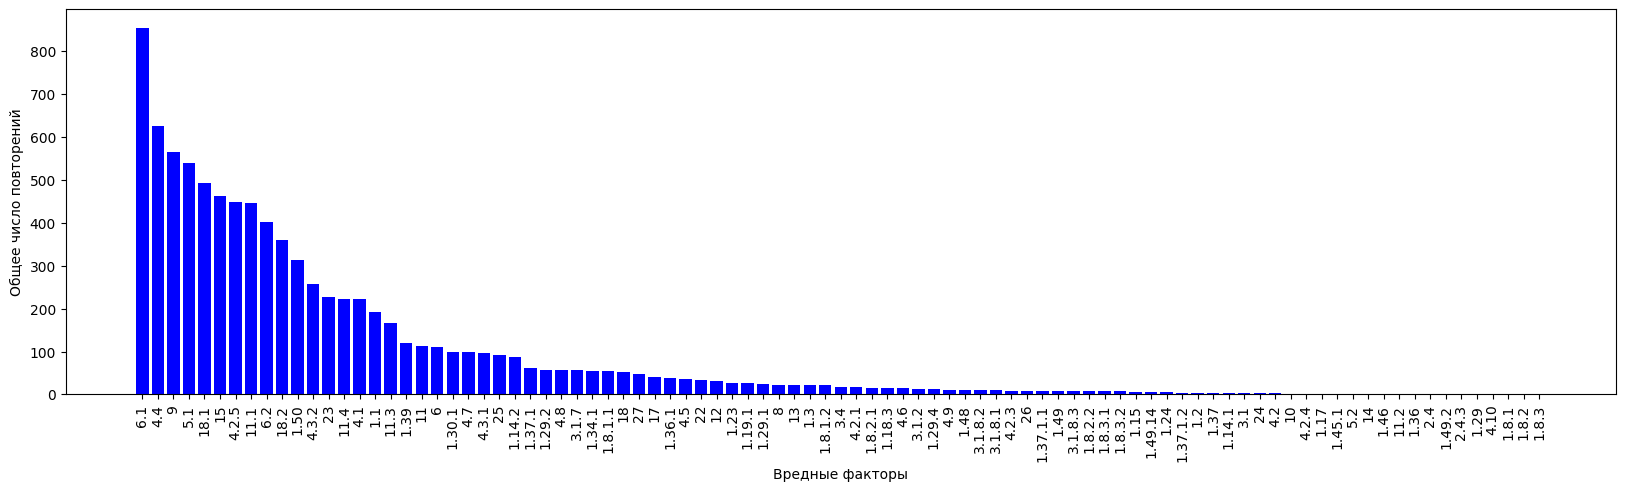

In [37]:
# Отобразим на столбчатую диаграмму - чачтоту использования наших признаков
plt.figure(figsize=(20, 5))
plt.bar(u_hf_sort_dict.keys(), u_hf_sort_dict.values(), color='blue')
plt.xticks(rotation=90)
plt.xlabel('Вредные факторы')
plt.ylabel('Общее число повторений')
plt.gca().set_facecolor('white')
plt.show()

In [38]:
# Формируем список уникальных значений вредных факторов 
# из наиболее часто встречающихся -> оставим первые 15
u_hf_lst = list(u_hf_sort_dict.keys())[:15]
del u_hf_dict
del u_hf_sort_dict

print(f'{len(u_hf_lst)}: u_hf_lst: {u_hf_lst}')

15: u_hf_lst: ['6.1', '4.4', '9', '5.1', '18.1', '15', '4.2.5', '11.1', '6.2', '18.2', '1.50', '4.3.2', '23', '11.4', '4.1']


In [39]:
#~~~~~~~~~~~~~~~~~~~~~~~~
#multi_hot_encoding
hf_mhe_lst = list()

# число классов
harmful_factors_class_count = len(u_hf_lst) + 1
# то есть по умолчанию выбираем индекс вредного фактора, которого нет в списке 
# наших выбранных и ограниченных уникальных вредных факторов
nan_inx = len(u_hf_lst)

# print(f'{len(col_lst)}: col_lst: {col_lst}')
# print(f'{len(u_hf_lst)}: u_hf_lst: {u_hf_lst}')
# print(f'harmful_factors_class_count: {harmful_factors_class_count}')
# print(f'nan_inx: {nan_inx}')

# пробегаемся по всем строкам колонки
for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}')
  # устанавливаем все признаки в нули
  i_mhe_lst = [0] * harmful_factors_class_count
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #расщепляем по запятым
      elem_lst = comma_string_split(i_elem)
      if len(elem_lst) > 0:
        for elem1_lst in elem_lst:
          # проверяем, есть ли этот элемент в списке
          if elem1_lst in u_hf_lst:
            inx = u_hf_lst.index(elem1_lst)
            i_mhe_lst[inx] = 1
          else:
            i_mhe_lst[nan_inx] = 1
      else:
        i_mhe_lst[nan_inx] = 1
    else:
      i_mhe_lst[nan_inx] = 1
  else:
    i_mhe_lst[nan_inx] = 1

  # print(f'  {len(i_mhe_lst)}: {i_mhe_lst}')
  hf_mhe_lst.append(i_mhe_lst)

# print(f'{len(hf_mhe_lst)}: hf_mhe_lst: {hf_mhe_lst}')

# добавляем новую колонку 'ВредныеФакторы' в 'df2'
df2 = df2.assign(ВредныеФакторы=hf_mhe_lst)

del hf_mhe_lst

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (2474, 4588), df2: (2474, 7)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


## МКБ

In [40]:
def getColNamesByFragmentName(str):
  '''
    Возвращает список названий колонок, в которых содержится заданная строка
    вход:
        str - часть названия колонки, например мкб
    выход:
        retVal - список названий колонок, содержащих заданную строку
  '''
  totalCols = list(df1.columns)
  retVal = [col for col in totalCols if str in col]
  return retVal

In [41]:
# Находим все колонки, в которых присутсвует часть названия '_МКБ'
fragment_str = '_МКБ'
mkb_cols = getColNamesByFragmentName(fragment_str)
print(f'Число колонок, содержащих "{fragment_str}": {len(mkb_cols)}')

Число колонок, содержащих "_МКБ": 92


In [42]:
# Формируем список уникальных значений мкб
# MKB Factors
u_mkb_lst = list()

for mkb_col in mkb_cols:
  col_inx = df1.columns.get_loc(mkb_col)
  col_lst = df1.iloc[:, col_inx].tolist()
  # print(f'df1 число строк: {df1.shape[0]}, mkb_col: {mkb_col}')
  # print(f'  len(col_lst): {len(col_lst)}, {col_lst}')
  # Пробегаем по всем строкам текущей колонки
  for i in range(df1.shape[0]):
    i_elem = col_lst[i]
    # print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}')
    # проверяем на nan
    if (i_elem == i_elem):
      # проверяем, что строка не пустая
      if i_elem:
        #print(f'{i}=>{df1.shape[0]}: i_elem: {i_elem}')
        #расщепляем по запятым
        elem_lst = comma_string_split(i_elem)
        #print(f'  {len(elem_lst)}: {elem_lst}')
        if len(elem_lst) > 0:
          for elem1_lst in elem_lst:
            #print(f'    elem1_lst: {elem1_lst}')
            if len(u_mkb_lst) > 0:
              # проверяем, что этого элемента нет в списке
              flag_lst = elem1_lst in u_mkb_lst
              if not flag_lst:
                u_mkb_lst.append(elem1_lst)
            else:
              u_mkb_lst.append(elem1_lst)

# print(f'{len(u_mkb_lst)}: u_mkb_lst: {u_mkb_lst}')

In [43]:
# создаем словарь МКБ: ключи - МКБ, значения - число повторений
u_mkb_dict = {}
for i_elem in u_mkb_lst:
  u_mkb_dict[i_elem] = 0

# print(f'{len(u_mkb_dict)}: u_mkb_lst: {u_mkb_dict}')

# пробегаемся по всем строкам колонок и заполняем словарь
for mkb_col in mkb_cols:
  col_inx = df1.columns.get_loc(mkb_col)
  col_lst = df1.iloc[:, col_inx].tolist()
  for i in range(df1.shape[0]):
    i_elem = col_lst[i]
    # проверяем на nan
    if (i_elem == i_elem):
      # проверяем, что строка не пустая
      if i_elem:
        #расщепляем по запятым
        elem_lst = comma_string_split(i_elem)
        if len(elem_lst) > 0:
          for elem1_lst in elem_lst:
            u_mkb_dict[elem1_lst] += 1

# print(f'{len(u_mkb_dict)}: u_mkb_lst: {u_mkb_dict}')

# сортируем словарь по убыванию
u_mkb_sort_dict = dict(sorted(u_mkb_dict.items(), key=lambda x: x[1], reverse=True))

# print(f'{len(u_mkb_sort_dict)}: u_mkb_sort_dict: {u_mkb_sort_dict}')

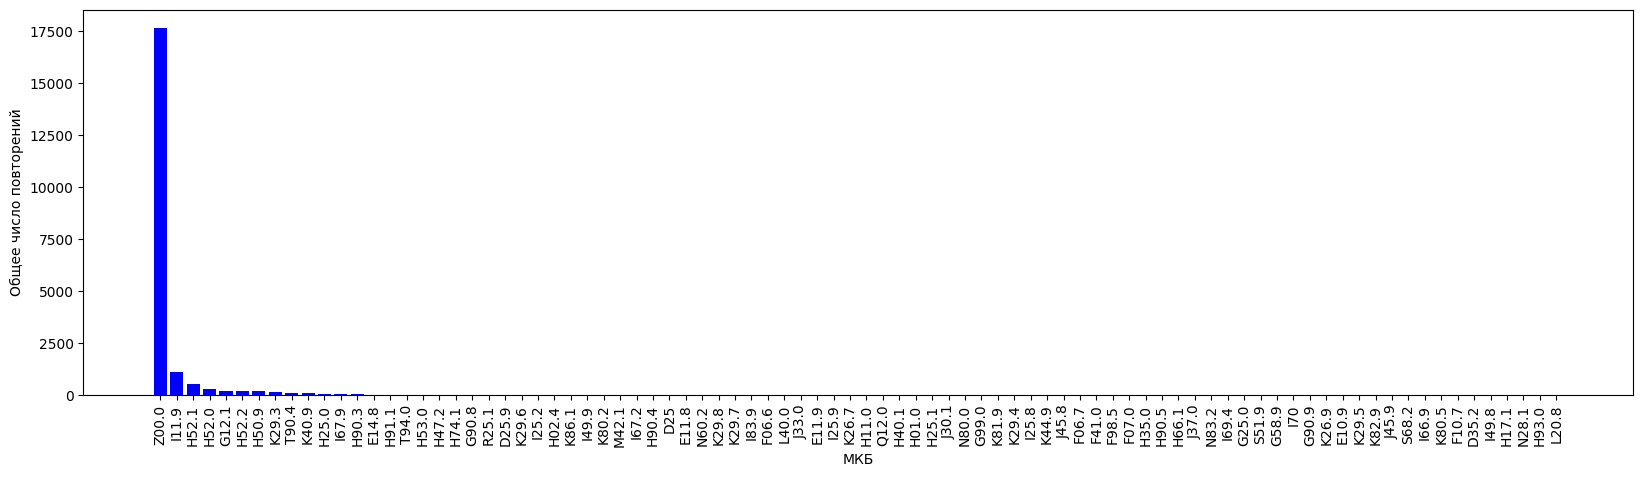

In [44]:
# Отобразим на столбчатую диаграмму - чачтоту использования наших признаков
plt.figure(figsize=(20, 5))
plt.bar(u_mkb_sort_dict.keys(), u_mkb_sort_dict.values(), color='blue')
plt.xticks(rotation=90)
plt.xlabel('МКБ')
plt.ylabel('Общее число повторений')
plt.gca().set_facecolor('white')
plt.show()

In [45]:
# Формируем список уникальных значений МКБ 
# из наиболее часто встречающихся -> оставим первые 3
u_mkb_lst = list(u_mkb_sort_dict.keys())[:3]
del u_mkb_dict
del u_mkb_sort_dict

print(f'{len(u_mkb_lst)}: u_mkb_lst: {u_mkb_lst}')

3: u_mkb_lst: ['Z00.0', 'I11.9', 'H52.1']


In [46]:
#~~~~~~~~~~~~~~~~~~~~~~~~
#multi_hot_encoding
mkb_mhe_lst = list()

# число классов
mkb_class_count = len(u_mkb_lst) + 1
# то есть по умолчанию выбираем индекс мкб, которого нет в списке 
# наших выбранных и ограниченных мкб факторов
nan_inx = len(u_mkb_lst)

for i in range(df1.shape[0]):
  i_mhe_lst = [0] * mkb_class_count
  mkb_mhe_lst.append(i_mhe_lst)

# print(f'{len(u_mkb_lst)}: u_hf_lst: {u_mkb_lst}')
# print(f'mkb_class_count: {mkb_class_count}')
# print(f'nan_inx: {nan_inx}')
# print(f'{len(mkb_mhe_lst)}: mkb_mhe_lst: {mkb_mhe_lst}')

# пробегаемся по всем строкам колонок и заполняем словарь
for mkb_col in mkb_cols:
  col_inx = df1.columns.get_loc(mkb_col)
  col_lst = df1.iloc[:, col_inx].tolist()
  # пробегаемся по всем строкам колонки
  for i in range(df1.shape[0]):
    i_elem = col_lst[i]
    # print(f'mkb_col: {mkb_col}: {i}->{df1.shape[0]}: i_elem: {i_elem}')
    # устанавливаем все признаки в нули
    i_mhe_lst = mkb_mhe_lst[i]
    # проверяем на nan
    if (i_elem == i_elem):
      # проверяем, что строка не пустая
      if i_elem:
        #расщепляем по запятым
        elem_lst = comma_string_split(i_elem)
        if len(elem_lst) > 0:
          for elem1_lst in elem_lst:
            # проверяем, есть ли этот элемент в списке
            if elem1_lst in u_mkb_lst:
              inx = u_mkb_lst.index(elem1_lst)
              i_mhe_lst[inx] = 1
            else:
              i_mhe_lst[nan_inx] = 1
        else:
          i_mhe_lst[nan_inx] = 1
      else:
        i_mhe_lst[nan_inx] = 1
    else:
      i_mhe_lst[nan_inx] = 1

  # print(f'  {len(i_mhe_lst)}: {i_mhe_lst}')
  mkb_mhe_lst[i] = i_mhe_lst

# print(f'{len(mkb_mhe_lst)}: mkb_mhe_lst: {mkb_mhe_lst}')

# добавляем новую колонку 'МКБ' в 'df2'
df2 = df2.assign(МКБ=mkb_mhe_lst)

del mkb_mhe_lst

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (2474, 4588), df2: (2474, 8)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы,МКБ
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[1, 0, 0, 1]"
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 1]"
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 1]"


## ГоденНегоден

# Числовые признаки

## Определяем числовые колонки

In [47]:
float_cols = list(df1.select_dtypes(include=['float64']).columns)
float_cols_count = len(float_cols)

print(f'Колоноки типа float: {float_cols_count}')
# for i in range(float_cols_count):
#   print(f'{i}: {float_cols[i]}')

Колоноки типа float: 1253


## Артериальное давление

In [48]:
# Находим все колонки, в которых присутсвует часть названия '_Артер'(АртериальноеДавление)
fragment_str = '_Артер'
# Arterial pressure
digit_cols = getColNamesByFragmentName(fragment_str)
print(f'Число колонок, содержащих "{fragment_str}": {len(digit_cols)}')

Число колонок, содержащих "_Артер": 20


In [49]:
# # пробегаемся по всем строкам колонок и заполняем словарь
# for dig_col in digit_cols:
#   col_inx = df1.columns.get_loc(dig_col)
#   col_lst = df1.iloc[:, col_inx].tolist()

#   # print(f'dig_col: {dig_col}')
#   # print(f'  len(col_lst): {len(col_lst)}: col_lst: {col_lst}')

#   # Терапия1_АртериальноеДавление_Значение
#   #   len(col_lst): 1571: col_lst: ['140/100', '150/100', '120/80', '120\\80', '110/70', '110/70', '105/70', '120/70', '140/80', '120/80', '120\\80', '130\\80', '125/85', '130\\80', '120\\80', '133', '120', '100', '120', '110',

#   # dig_col: Терапия1_АртериальноеДавление21_Значение
#   #   len(col_lst): 1571: col_lst: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 82.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 60.0, 80.0, 70.0, 90.0, 110.0, nan, 70.0, 80.0, 120.0, 70.

#    # 2023.06.02. выбираю колонку Терапия1_АртериальноеДавление21_Значение

In [50]:
# Колонка Терапия1_АртериальноеДавление21_Значение
nan_lst = df1[df1['Терапия1_АртериальноеДавление21_Значение'].isnull()].index
nan_lst_count_proc = len(nan_lst)*100/df2.size
print(f'df1 число строк: {df1.shape[0]}')
print(f'"Терапия1_АртериальноеДавление21_Значение": число строк с пустыми значениями: {len(nan_lst)}, {round(nan_lst_count_proc, 2)}%')

min_val = df1['Терапия1_АртериальноеДавление21_Значение'].min()
max_val = df1['Терапия1_АртериальноеДавление21_Значение'].max()
mean_val = df1['Терапия1_АртериальноеДавление21_Значение'].mean()
print(f'Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}')

df1 число строк: 2474
"Терапия1_АртериальноеДавление21_Значение": число строк с пустыми значениями: 447, 2.26%
Значения: min: 20.0, max: 805.0, mean: 80.64


In [51]:
# Находим минимальное максимальное значения, пустые значения заполняем средним
f_arr = df1['Терапия1_АртериальноеДавление21_Значение'].values.astype('float64')

# f_indices = []
# for i in range(len(f_arr)):
#   if f_arr[i] > 200.0:
#     f_indices.append(i)
# print(f_indices)
# print(f'f_indices[0]: {f_indices[0]}:, {f_arr[f_indices[0]]}')
# print(f'f_indices[1]: {f_indices[1]}:, {f_arr[f_indices[1]]}')
# del f_indices

f_arr_lst = list()
for i in range(len(f_arr)):
  # print(f'{i}: {f_arr[i]}')
  # проверяем на nan
  if (f_arr[i] == f_arr[i]):
    f_arr_lst.append(f_arr[i])

f_arr2 = np.array(f_arr_lst, dtype=np.float64)

# print(f'len(f_arr_lst): {len(f_arr_lst)}:, {f_arr_lst}')
# print(f'len(f_arr2): {len(f_arr2)}:, {f_arr2}')

del f_arr_lst

min_val = np.min(f_arr2)
max_val = np.max(f_arr2)
mean_val = np.mean(f_arr2)
print(f'{f_arr2.shape}: Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}')

for i in range(len(f_arr2)):
  if f_arr2[i] > 200.0:
    f_arr2[i] /= 10.0

min_val = np.min(f_arr2)
max_val = np.max(f_arr2)
mean_val = np.mean(f_arr2)
print(f'{f_arr2.shape}: Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}')

# Заполняем пустые ячейки и убираем выбросы
for i in range(len(f_arr)):
  # проверяем на nan
  if (f_arr[i] == f_arr[i]):
    if f_arr[i] > 200.0:
      f_arr[i] /= 10.0
  else:
    f_arr[i] = mean_val

del f_arr2

min_val = np.min(f_arr)
max_val = np.max(f_arr)
mean_val = np.mean(f_arr)
max_min_delta = max_val - min_val
print(f'{f_arr.shape}: Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}, max_min_delta: {round(max_min_delta, 2)}')

# Проведем min-max нормирвоание
for i in range(len(f_arr)):
  f_arr[i] = (f_arr[i] - min_val)/max_min_delta

min_val = np.min(f_arr)
max_val = np.max(f_arr)
mean_val = np.mean(f_arr)
print(f'{f_arr.shape}: Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}')

(2027,): Значения: min: 20.0, max: 805.0, mean: 80.64
(2027,): Значения: min: 20.0, max: 120.0, mean: 79.93
(2474,): Значения: min: 20.0, max: 120.0, mean: 79.93, max_min_delta: 100.0
(2474,): Значения: min: 0.0, max: 1.0, mean: 0.6


In [52]:
# добавляем новую колонку 'АртДавление'('АртериальноеДавление') в 'df2'
df2 = df2.assign(АртДавление=f_arr)
print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (2474, 4588), df2: (2474, 9)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы,МКБ,АртДавление
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[1, 0, 0, 1]",0.599268
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 1]",0.599268
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 1]",0.599268


## ИМТ - индекс массы тела

In [53]:
# Находим все колонки, в которых присутсвует часть названия '_Артер'(АртериальноеДавление)
fragment_str = '_ИМТ'
# Arterial pressure
digit_cols = getColNamesByFragmentName(fragment_str)
print(f'Число колонок, содержащих "{fragment_str}": {len(digit_cols)}')

Число колонок, содержащих "_ИМТ": 10


In [54]:
# # пробегаемся по всем строкам колонок и заполняем словарь
# for dig_col in digit_cols:
#   col_inx = df1.columns.get_loc(dig_col)
#   col_lst = df1.iloc[:, col_inx].tolist()

#   print(f'dig_col: {dig_col}')
#   print(f'  len(col_lst): {len(col_lst)}: col_lst: {col_lst}')

# Терапия1_ИМТ_Значение
# len(col_lst): 1571: col_lst: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, '22.53', '29.74', '19.92', '29.37', '23.24', '2.52', '30.08'
# Терапия1_ИМТ_ЗначениеПредставление
# len(col_lst): 1571: col_lst: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 22.53, 29.74, 19.92, 29.37, 23.24, 2.52, 30.08, 24.06, 30.12, 23.92,

In [55]:
# df1['Терапия1_ИМТ_Значение'].dtype
# dtype('O')

# df1['Терапия1_ИМТ_ЗначениеПредставление'].dtype
# dtype('float64')

In [56]:
# Колонка Терапия1_ИМТ_ЗначениеПредставление
nan_lst = df1[df1['Терапия1_ИМТ_ЗначениеПредставление'].isnull()].index
nan_lst_count_proc = len(nan_lst)*100/df2.size
print(f'df1 число строк: {df1.shape[0]}')
print(f'"Терапия1_ИМТ_ЗначениеПредставление": число строк с пустыми значениями: {len(nan_lst)}, {round(nan_lst_count_proc, 2)}%')

min_val = df1['Терапия1_ИМТ_ЗначениеПредставление'].min()
max_val = df1['Терапия1_ИМТ_ЗначениеПредставление'].max()
mean_val = df1['Терапия1_ИМТ_ЗначениеПредставление'].mean()
print(f'Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}')

df1 число строк: 2474
"Терапия1_ИМТ_ЗначениеПредставление": число строк с пустыми значениями: 512, 2.3%
Значения: min: 0.19, max: 49.38, mean: 26.54


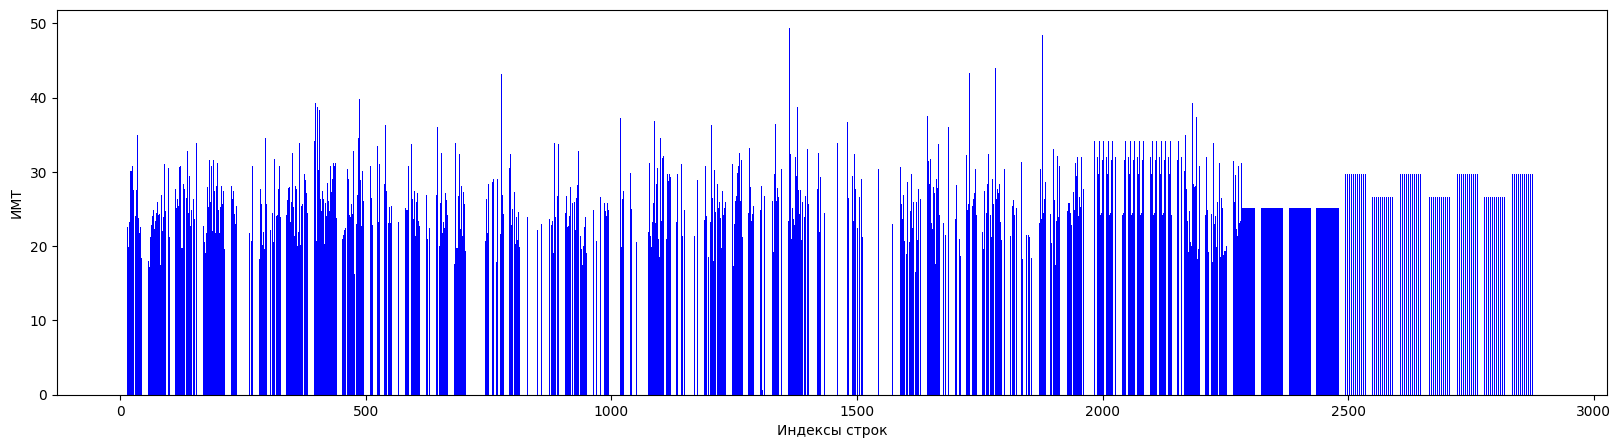

In [57]:
plt.figure(figsize=(20, 5))
plt.bar(df1.index, df1['Терапия1_ИМТ_ЗначениеПредставление'], color='blue')
#plt.xticks(rotation=90)
plt.xlabel('Индексы строк')
plt.ylabel('ИМТ')
#plt.gca().set_facecolor('white')
plt.rcParams['axes.facecolor'] = 'white'
plt.show()

In [58]:
# Находим минимальное максимальное значения, пустые значения заполняем средним
f_arr = df1['Терапия1_ИМТ_ЗначениеПредставление'].values.astype('float64')

f_arr_lst = list()
for i in range(len(f_arr)):
  # проверяем на nan
  if (f_arr[i] == f_arr[i]):
    f_arr_lst.append(f_arr[i])
f_arr2 = np.array(f_arr_lst, dtype=np.float64)
del f_arr_lst

min_val = np.min(f_arr2)
max_val = np.max(f_arr2)
mean_val = np.mean(f_arr2)
print(f'{f_arr2.shape}: Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}')

# Заполняем пустые ячейки и убираем выбросы
for i in range(len(f_arr)):
  # проверяем на nan
  if not (f_arr[i] == f_arr[i]):
    f_arr[i] = mean_val
del f_arr2

min_val = np.min(f_arr)
max_val = np.max(f_arr)
mean_val = np.mean(f_arr)
max_min_delta = max_val - min_val
print(f'{f_arr.shape}: Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}, max_min_delta: {round(max_min_delta, 2)}')

# Проведем min-max нормирвоание
for i in range(len(f_arr)):
  f_arr[i] = (f_arr[i] - min_val)/max_min_delta

min_val = np.min(f_arr)
max_val = np.max(f_arr)
mean_val = np.mean(f_arr)
print(f'{f_arr.shape}: Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}')

(1962,): Значения: min: 0.19, max: 49.38, mean: 26.54
(2474,): Значения: min: 0.19, max: 49.38, mean: 26.54, max_min_delta: 49.19
(2474,): Значения: min: 0.0, max: 1.0, mean: 0.54


In [59]:
# добавляем новую колонку 'ИМТ' в 'df2'
df2 = df2.assign(ИМТ=f_arr)
print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (2474, 4588), df2: (2474, 10)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы,МКБ,АртДавление,ИМТ
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[1, 0, 0, 1]",0.599268,0.535597
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 1]",0.599268,0.535597
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 1]",0.599268,0.535597


# TODO Простые текстовые признаки

TODO -> добавить с использованием токенайзера

TODO -> иcпользовать три модели functional api

In [60]:
# #~~~~~~~~~~~~~~~~~~~~~~~~
# # TODO добавить с использованием токенайзера
# #~~~~~~~~~~~~~~~~~~~~~~~~


# # Цех
# #~~~~~~~~~~~~~~~~~~~~~~~~
# # unique_lst = df1['Цех'].unique().tolist()
# # print(f'{len(unique_lst)}: {unique_lst}')
# nan_lst = df1[df1['Цех'].isnull()].index
# print(f'"Цех": число строк с пустыми значениями: {len(nan_lst)}')

# # Колонка "Цех" содержит пустые значения, заполняем их значением "x"
# df1['Цех'].fillna('x', inplace=True)
# nan_lst = df1[df1['Цех'].isnull()].index
# print(f'"Цех": число строк с пустыми значениями после заполнения значением "x": {len(nan_lst)}')

# #TODO -> токенайзер

In [61]:
# #Профессия
# #~~~~~~~~~~~~~~~~~~~~~~~~
# unique_lst = df1['Профессия'].unique().tolist()
# print(f'{len(unique_lst)}: {unique_lst}')
# nan_lst = df1[df1['Профессия'].isnull()].index
# print(f'"Профессия": число строк с пустыми значениями: {len(nan_lst)}')

# #~~~~~~~~~~~~~~~~~~~~~~~~
# # col_inx = df1.columns.get_loc('Профессия')
# # col_lst = df1.iloc[:, col_inx].tolist()

# #TODO -> токенайзер

# Проверка таблицы на пустые ячейки

In [62]:
print(f'df2 число строк: {df2.shape[0]}')
print(f'df2 число колонок: {df2.shape[1]}')

nan_cell_count = df2.isna().sum().sum()
nan_cell_count_proc = nan_cell_count*100/df2.size
print(f'общее количество пропусков во всей таблице df2: {nan_cell_count}, {round(nan_cell_count_proc, 2)}%')

df2 число строк: 2474
df2 число колонок: 10
общее количество пропусков во всей таблице df2: 0, 0.0%


# Удаляем переменные, которые не используем, чтобы освободить память

In [63]:
# # удаление переменных, освобождение памяти

del df1
# del nan_cell_count
# del nan_cell_count_proc
# del i_arr
# del u_lst
# del col_inx
# del col_lst
# del i_arr2
# del ohe_lst2

# del age_class_count
# del nan_lst

# del dispensary_class_count

# del u_hf_lst
# del harmful_factors_class_count
# del nan_inx
# del inx

# del fragment_str
# del mkb_cols
# del u_mkb_lst
# del mkb_class_count

# del f_arr

# Обучение Нейросети


## Разделяем на отдельные выборки

In [64]:
print(f'размеры датафрейма df2: {df2.shape}')
df2.head(3)

размеры датафрейма df2: (2474, 10)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы,МКБ,АртДавление,ИМТ
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[1, 0, 0, 1]",0.599268,0.535597
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 0, 1]",0.599268,0.535597
2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 1]",0.599268,0.535597


In [65]:
# Перемешиваем строки в нашей таблице
df2_shuffle = df2.sample(frac=1).reset_index(drop=True)
print(f'размеры датафрейма df2_shuffle: {df2_shuffle.shape}')
df2_shuffle.head(3)

размеры датафрейма df2_shuffle: (2474, 10)


,ЗаключениеМКК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы,МКБ,АртДавление,ИМТ
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[1, 0, 0, 1]",0.500000,0.573694
1,"[1, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[1, 0, 0, 0, 0]","[0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1]","[1, 0, 0, 1]",0.599268,0.535597
2,"[0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",0,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 1]",0.600000,0.418174


In [66]:
# y_data
# преобразуем списки в отдельные колонки
df_y = df2_shuffle['ЗаключениеМКК'].apply(pd.Series)
print(f'размеры датафрейма df4: {df_y.shape}')
# преобразуем в numpy массив типа float
y_data = df_y.astype(float).to_numpy()
print('Количество осей: ', y_data.ndim)
print('Форма массива: ', y_data.shape)
print('Количество значений: ', y_data.size)

размеры датафрейма df4: (2474, 3)
Количество осей:  2
Форма массива:  (2474, 3)
Количество значений:  7422


In [67]:
# x1_data -> категориальные признаки
df_x1 = df2_shuffle.drop(['ЗаключениеМКК','АртДавление','ИМТ'], axis = 1)
df_x1.head(3)

,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы,МКБ
0,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[1, 0, 0, 1]"
1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[1, 0, 0, 0, 0]","[0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1]","[1, 0, 0, 1]"
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",0,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 1]"


In [68]:
# x2_data -> числовые признаки
df_x2 = df2_shuffle.drop(['ЗаключениеМКК','Возраст','КлиентПол','ТипМедосмотра','ПсихОсвидетельствование','ДиспансернаяГруппа','ВредныеФакторы','МКБ'], axis = 1)
df_x2.head(3)

,АртДавление,ИМТ
0,0.500000,0.573694
1,0.599268,0.535597
2,0.600000,0.418174


In [69]:
# Формируем массив x1_data
# трансформируем списки в отдельные колонки (для df_x1)
split_col_names = list()
split_col_names.append('Возраст')
split_col_names.append('ДиспансернаяГруппа')
split_col_names.append('ВредныеФакторы')
split_col_names.append('МКБ')

for col_name in split_col_names:
  df_x1 = pd.concat([df_x1.drop(col_name, axis=1), df_x1[col_name].apply(pd.Series)], axis=1)

# преобразуем в numpy массив типа float
x1_data = df_x1.astype(float).to_numpy()
print('Количество осей: ', x1_data.ndim)
print('Форма массива: ', x1_data.shape)
print('Количество значений: ', x1_data.size)

del split_col_names

Количество осей:  2
Форма массива:  (2474, 39)
Количество значений:  96486


In [70]:
# Формируем массив x2_data
x2_data = df_x2.astype(float).to_numpy()
print('Количество осей: ', x2_data.ndim)
print('Форма массива: ', x2_data.shape)
print('Количество значений: ', x2_data.size)

Количество осей:  2
Форма массива:  (2474, 2)
Количество значений:  4948


In [71]:
# del df2

del df2_shuffle
del df_y
del df_x1
del df_x2

## Общие настройки и функции

In [72]:
# Переменные-настройки-параметры-для-обучения-сети
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
EPOCHS = 50
VERBOSE = 1
TEST_SIZE_PERCENT = 0.2

#~~~~~~~~~~~~~~~~~~~~~~~~
print(f'LEARNING_RATE: {LEARNING_RATE}')
print(f'BATCH_SIZE: {BATCH_SIZE}')
print(f'EPOCHS: {EPOCHS}')
print(f'VERBOSE: {VERBOSE}')
print(f'TEST_SIZE_PERCENT: {TEST_SIZE_PERCENT}')

LEARNING_RATE: 0.001
BATCH_SIZE: 128
EPOCHS: 50
VERBOSE: 1
TEST_SIZE_PERCENT: 0.2


In [73]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Графическое представление результатов работы нейросети
#~~~~~~~~~~~~~~~~~~~~~~~~
def printNNChart(history_n):
  '''
    Отображенние на графике результатов работы нейронной сети (Neural Network)
    вход:
        history_n: массив результатов работы нейросети
  '''
  # Создание полотна для рисунка
  plt.figure(figsize=(18,5))

  # Задание первой (левой) области для построения графиков
  plt.subplot(1, 2, 1)
  # Отрисовка графиков 'loss' и 'val_loss' из значений словаря history.history
  plt.plot(history_n.history['loss'],
           label = 'Значение ошибки на обучающем наборе')
  plt.plot(history_n.history['val_loss'],
           label = 'Значение ошибки на проверочном наборе')
  # Задание подписей осей
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Значение ошибки')
  plt.legend()
  plt.grid(which = 'major', color = 'black', alpha = 0.3)
  plt.minorticks_on()
  plt.grid(which = 'minor', color = 'gray', linestyle = '--', alpha = 0.3)

  # Задание второй (правой) области для построения графиков
  plt.subplot(1, 2, 2)
  # Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря history.history
  plt.plot(history_n.history['accuracy'],
         label = 'Доля верных ответов на обучающем наборе')
  plt.plot(history_n.history['val_accuracy'],
           label = 'Доля верных ответов на проверочном наборе')
  # Задание подписей осей
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.grid(which = 'major', color = 'black', alpha = 0.3)
  plt.minorticks_on()
  plt.grid(which = 'minor', color = 'gray', linestyle = '--', alpha = 0.3)

  # Фиксация графиков и рисование всей картинки
  plt.show()

## Простая нейронка на категориальных признаках

In [74]:
# Создание обучающей и тестовой выборки
x_train, x_test, y_train, y_test = train_test_split(x1_data, # набор параметров
                                                    y_data, # набор меток классов
                                                    test_size=TEST_SIZE_PERCENT, # процент в тестовую
                                                    shuffle=True, #  перемешивание
                                                    random_state=3) # воспроизводимость
# Выведем размерность полученных выборок
print('Обучающая выборка параметров', x_train.shape)
print('Обучающая выборка меток классов', y_train.shape)
print()
print('Тестовая выборка параметров', x_test.shape)
print('Тестовая выборка меток классов', y_test.shape)

Обучающая выборка параметров (1979, 39)
Обучающая выборка меток классов (1979, 3)

Тестовая выборка параметров (495, 39)
Тестовая выборка меток классов (495, 3)


In [75]:
# Создание модели
model1 = Sequential()

# Добавление слоев
model1.add(Dense(60, input_dim=x_train.shape[1], activation='relu'))

model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(30))

model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(10))

model1.add(Dense(3, activation = 'softmax'))

In [76]:
# Компиляция
model1.compile(loss='categorical_crossentropy', 
               optimizer=Adam(learning_rate=LEARNING_RATE), 
               metrics=['accuracy'])

In [77]:
# Обучение нейронной сети
history1 = model1.fit(x_train,                             # Обучающая выборка параметров
                      y_train,                             # Обучающая выборка меток класса
                      batch_size=BATCH_SIZE,               # Размер батча (пакета)
                      epochs=EPOCHS,                       # Количество эпох обучения
                      validation_split=TEST_SIZE_PERCENT,  # Доля проверочной выборки
                      verbose=VERBOSE)                     # Отображение хода обучения

Epoch 1/50
13/13 [==============================] - 3s 36ms/step - loss: 1.3579 - accuracy: 0.4371 - val_loss: 0.8893 - val_accuracy: 0.6692
Epoch 2/50
13/13 [==============================] - 0s 8ms/step - loss: 0.8391 - accuracy: 0.6507 - val_loss: 0.7976 - val_accuracy: 0.8611
Epoch 3/50
13/13 [==============================] - 0s 8ms/step - loss: 0.6708 - accuracy: 0.7252 - val_loss: 0.7310 - val_accuracy: 0.7879
Epoch 4/50
13/13 [==============================] - 0s 7ms/step - loss: 0.5637 - accuracy: 0.7827 - val_loss: 0.6737 - val_accuracy: 0.8005
Epoch 5/50
13/13 [==============================] - 0s 6ms/step - loss: 0.4926 - accuracy: 0.8143 - val_loss: 0.6288 - val_accuracy: 0.7980
Epoch 6/50
13/13 [==============================] - 0s 5ms/step - loss: 0.4475 - accuracy: 0.8200 - val_loss: 0.5922 - val_accuracy: 0.7904
Epoch 7/50
13/13 [==============================] - 0s 5ms/step - loss: 0.4119 - accuracy: 0.8231 - val_loss: 0.5582 - val_accuracy: 0.7980
Epoch 8/50
13/13 [=

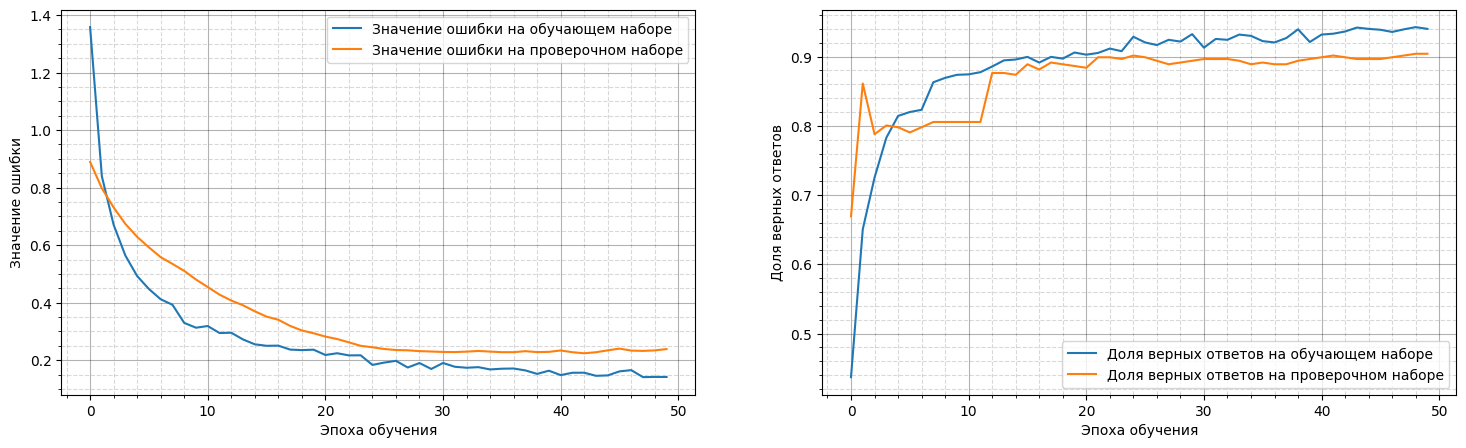

In [78]:
# Отобразим результаты на графике
printNNChart(history1)

In [79]:
# Оценим результат работы нашей сети.
# Применим метод .evaluate() к нашей модели, в качестве параметров 
# передадим ему тестовые выборки и согласие на отображение хода вычисления.

scores1 = model1.evaluate(x_test,
                          y_test,
                          verbose=1)

print('Процент верных ответов на тестовых данных:', round(scores1[1],2) * 100, '%')

16/16 [==============================] - 0s 4ms/step - loss: 0.2120 - accuracy: 0.8889
Процент верных ответов на тестовых данных: 89.0 %


In [130]:
# Вывод значения точности распознавания на проверочной выборке по эпохам
print(f'Эпохи: {EPOCHS}')
print("="*50)

# val_accuracy
val_acc1 = history1.history['val_accuracy']
i_max = 0
val_acc_max = -1.0
for i in range(EPOCHS):
  # print(f'{i}->{EPOCHS}: {round(val_acc1[i], 3)}%')
  if val_acc1[i] > val_acc_max:
    val_acc_max = val_acc1[i]
    i_max = i

print(f'Самая точная нейронка под номером: {i_max} из {EPOCHS} эпох')
print(f'  достигла точности: {round(val_acc1[i]*100., 3)}%')

Эпохи: 50
Самая точная нейронка под номером: 48 из 50 эпох
  достигла точности: 90.404%


## F1Score

In [100]:
# Распознавание ЗаключениеМК на тестовой выборке
# x_test, y_test -> массивы, которые не принимали участия в обучении нейронки
print('x_test, y_test -> массивы, которые не принимали участия в обучении нейронки:')
print('  x_test:')
print('    Количество осей: ',x_test.ndim)
print('    Форма массива: ',x_test.shape)
print('    Количество значений: ',x_test.size)
print('  y_test:')
print('    Количество осей: ',y_test.ndim)
print('    Форма массива: ',y_test.shape)
print('    Количество значений: ',y_test.size)

x_test, y_test -> массивы, которые не принимали участия в обучении нейронки:
  x_test:
    Количество осей:  2
    Форма массива:  (495, 39)
    Количество значений:  19305
  y_test:
    Количество осей:  2
    Форма массива:  (495, 3)
    Количество значений:  1485


In [120]:
# print(f'x_test.shape[0]: {x_test.shape[0]}, x_test.shape[1]: {x_test.shape[1]}')
# print(f'y_test.shape[0]: {y_test.shape[0]}, y_test.shape[1]: {y_test.shape[1]}')

pred1 = model1.predict(x_test)

# У нас три класса:
# 0 - негоден, 1 - годен с ограничениями, 2 - годен
# Подсчитаем по каждому верное и неверное предсказания
arr_true = np.zeros(3, dtype=int)
arr_false = np.zeros(3, dtype=int)

# print(arr_true)
# print(arr_false)

for i in range(y_test.shape[0]):
  # print(f'{i}->{y_test.shape[0]}: {y_test[i,:]}')
  # Получение индекса самого большого элемента
  y_inx_max = np.argmax(y_test[i,:])
  # print(f'  y_inx_max: {y_inx_max}')
  #~~~
  # print(f'{i}->{pred1.shape[0]}: {pred1[i,:]}')
  pred_inx_max = np.argmax(pred1[i,:])
  # print(f'  pred_inx_max: {pred_inx_max}')
  #~~~
  if y_inx_max == pred_inx_max:
    # верное предсказание
    arr_true[y_inx_max] += 1
  else:
    # неверное предсказания
    arr_false[y_inx_max] += 1

# Результаты предсказаний по тестовой выборке
print('Результаты предсказаний по тестовой выборке:')
print(f'  размер тествой выборки: {y_test.shape[0]}')
print(f'  0 - негоден, предсказания:')
print(f'     верное: {arr_true[0]}')
print(f'     неверное: {arr_false[0]}')
print(f'  1 - годен с ограничениями, предсказания:')
print(f'     верное: {arr_true[1]}')
print(f'     неверное: {arr_false[1]}')
print(f'  2 - годен:')
print(f'     верное: {arr_true[2]}')
print(f'     неверное: {arr_false[2]}')

print('проверочная сумма:')

print(f'  {y_test.shape[0]} -> {arr_true[0]+arr_false[0]+arr_true[1]+arr_false[1]+arr_true[2]+arr_false[2]}')

16/16 [==============================] - 0s 1ms/step
Результаты предсказаний по тестовой выборке:
  размер тествой выборки: 495
  0 - негоден, предсказания:
     верное: 78
     неверное: 0
  1 - годен с ограничениями, предсказания:
     верное: 112
     неверное: 29
  2 - годен:
     верное: 250
     неверное: 26
проверочная сумма:
  495 -> 495


<Axes: xlabel='ЗаключениеМК', ylabel='Число ответов'>

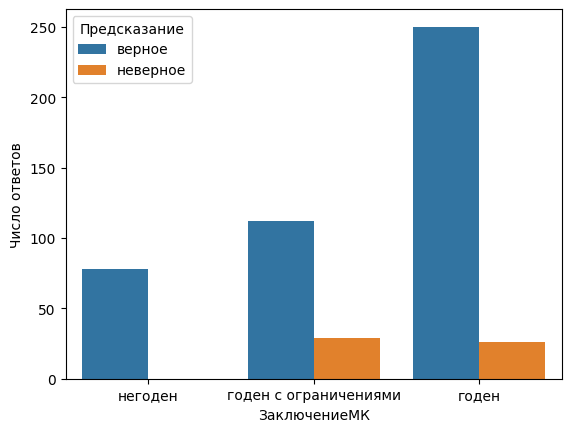

In [124]:
# Импортирум саму библиотеку Seaborn и указываем, что будем использовать ее под псевдонимом sns
import seaborn as sns

conclusion_lst = ['негоден', 'годен с ограничениями', 'годен']

df_conclusion = pd.DataFrame({'ЗаключениеМК': ['негоден','негоден','годен с ограничениями','годен с ограничениями','годен','годен'],
                              'Предсказание': ['верное','неверное','верное','неверное','верное','неверное'],
                              'Число ответов': [arr_true[0],arr_false[0],arr_true[1],arr_false[1],arr_true[2],arr_false[2]]})

sns.barplot(x="ЗаключениеМК", y="Число ответов", hue="Предсказание", data=df_conclusion)
# df_conclusion

## Модель FunctionalAPI (Составная нейронка)

In [125]:
print('y_data:')
print('  Количество осей: ',y_data.ndim)
print('  Форма массива: ',y_data.shape)
print('  Количество значений: ',y_data.size)

print('x1_data:')
print('  Количество осей: ',x1_data.ndim)
print('  Форма массива: ',x1_data.shape)
print('  Количество значений: ',x1_data.size)

print('x2_data:')
print('  Количество осей: ',x2_data.ndim)
print('  Форма массива: ',x2_data.shape)
print('  Количество значений: ',x2_data.size)

#~~~~~~~~~~~~~~~~~~~~~~~~
input1 = Input((x1_data.shape[1],))
input2 = Input((x2_data.shape[1],))
# input3 = Input((x3_data.shape[1],))

#~~~~~~~~~~~~~~~~~~~~~~~~
# Создаем ветку х1
# x1 = BatchNormalization()(input1) # Создаем ветку х1
# x1 = Dropout(0.5)(x1)
# x1 = Dense(10, activation="relu")(x1)
# x1 = Dense(1000, activation="relu")(x1)
# x1 = Dense(100, activation = "relu")(x1)

x1 = Dense(60, activation="relu")(input1)

x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)
x1 = Dense(30, activation="relu")(x1)

x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)
x1 = Dense(10, activation="relu")(x1)

#~~~~~~~~~~~~~~~~~~~~~~~~
# Создаем ветку х2
x2 = Dense(60, activation="relu")(input2)

x2 = BatchNormalization()(x2)
x2 = Dropout(0.2)(x2)
x2 = Dense(30, activation="relu")(x2)

x2 = BatchNormalization()(x2)
x2 = Dropout(0.2)(x2)
x2 = Dense(10, activation="relu")(x2)

#~~~~~~~~~~~~~~~~~~~~~~~~
# Объединяем все две(три) ветки
x = concatenate([x1, x2])
x = Dense(5, activation='relu')(x)
x = Dropout(0.5)(x)
# Финальные нейроны
x = Dense(3, activation='softmax')(x) 

#~~~~~~~~~~~~~~~~~~~~~~~~
# В Model загружаем стартовые и последнюю точки 
model2 = Model((input1, input2), x)


y_data:
  Количество осей:  2
  Форма массива:  (2474, 3)
  Количество значений:  7422
x1_data:
  Количество осей:  2
  Форма массива:  (2474, 39)
  Количество значений:  96486
x2_data:
  Количество осей:  2
  Форма массива:  (2474, 2)
  Количество значений:  4948


In [126]:
# Компиляция
model2.compile(loss='categorical_crossentropy', 
               optimizer=Adam(learning_rate=LEARNING_RATE), 
               metrics=['accuracy'])

In [127]:
# history2 = model2.fit([xTrain01[:50000], xTrainRez01[:50000]], 
#                     yTrain[:50000], 
#                     epochs= 80, 
#                     validation_data=([xTrain01[50000:], xTrainRez01[50000:]], 
#                     yTrain[50000:]), 
#                     verbose=1, shuffle=True)

history2 = model2.fit([x1_data[:1800], x2_data[:1800]], 
                      y_data[:1800], 
                      epochs= 50, 
                      validation_data=([x1_data[1800:], x2_data[1800:]], 
                      y_data[1800:]), 
                      verbose=1, shuffle=True)

Epoch 1/50
57/57 [==============================] - 4s 9ms/step - loss: 1.0984 - accuracy: 0.5222 - val_loss: 1.0566 - val_accuracy: 0.5801
Epoch 2/50
57/57 [==============================] - 0s 4ms/step - loss: 0.9298 - accuracy: 0.5761 - val_loss: 0.9946 - val_accuracy: 0.5801
Epoch 3/50
57/57 [==============================] - 0s 4ms/step - loss: 0.8750 - accuracy: 0.5811 - val_loss: 0.8881 - val_accuracy: 0.5801
Epoch 4/50
57/57 [==============================] - 0s 4ms/step - loss: 0.8118 - accuracy: 0.5933 - val_loss: 0.7863 - val_accuracy: 0.6098
Epoch 5/50
57/57 [==============================] - 0s 4ms/step - loss: 0.7842 - accuracy: 0.6000 - val_loss: 0.7055 - val_accuracy: 0.6128
Epoch 6/50
57/57 [==============================] - 0s 4ms/step - loss: 0.7413 - accuracy: 0.6061 - val_loss: 0.6425 - val_accuracy: 0.6142
Epoch 7/50
57/57 [==============================] - 0s 4ms/step - loss: 0.7093 - accuracy: 0.6172 - val_loss: 0.5925 - val_accuracy: 0.6944
Epoch 8/50
57/57 [==

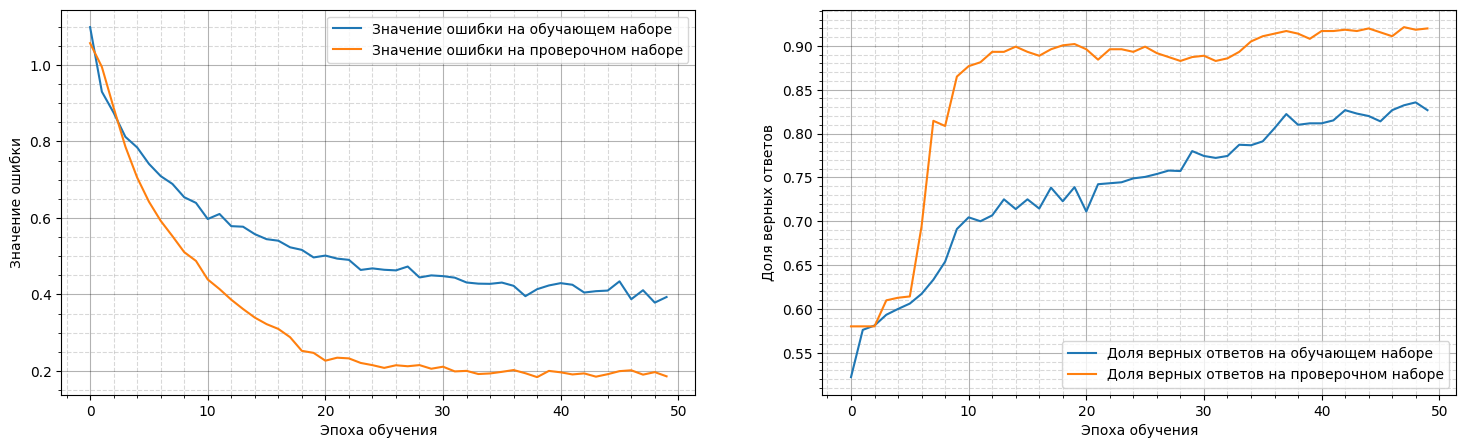

In [132]:
# Отобразим результаты на графике
printNNChart(history2)

In [133]:
# Вывод значения точности распознавания на проверочной выборке по эпохам
print(f'Эпохи: {EPOCHS}')
print("="*50)

# val_accuracy
val_acc2 = history2.history['val_accuracy']
i_max = 0
val_acc_max = -1.0
for i in range(EPOCHS):
  # print(f'{i}->{EPOCHS}: {round(val_acc1[i], 3)}%')
  if val_acc2[i] > val_acc_max:
    val_acc_max = val_acc2[2]
    i_max = i

print(f'Самая точная нейронка под номером: {i_max} из {EPOCHS} эпох')
print(f'  достигла точности: {round(val_acc2[i]*100., 3)}%')

Эпохи: 50
Самая точная нейронка под номером: 49 из 50 эпох
  достигла точности: 91.988%
